#Step1 Import librairies and dataset

In [ ]:
# Load, explore and plot data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
# Train test split
from sklearn.model_selection import train_test_split
# Text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import re
# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

!pip install nlpaug
import nlpaug.augmenter.word as naw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 6.7 MB/s eta 0:00:00


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving OUTPUT_FINAL.xlsx to OUTPUT_FINAL.xlsx
User uploaded file "OUTPUT_FINAL.xlsx" with length 297999 bytes


In [ ]:
data=pd.read_excel('OUTPUT_FINAL.xlsx')

# rename the columns
data = data[['Reason','Status']]
data.head()

,Reason,Status
0,"Due to death, please refer to attached doc. \n...",Refunded
1,"Due to death, please refer to attached doc. \n...",Refunded
2,BIZPLUS Fare - full refund,Refunded
3,Refund using auth code; SMRM:85183/GEN24,Refunded
4,Full refund with approval code: FATN591-24.,Refunded


In [ ]:
data.describe()

,Reason,Status
count,6637,6719
unique,2280,3
top,Full refund as per ticket TNC - Plus Fare.,Refunded
freq,152,5863


In [ ]:
data.groupby('Status').describe().T

Status         PARTIAL_REFUND                                    Refunded  \
Reason count               58                                        5817   
       unique              37                                        1916   
       top     SCA - REROUTED  Full refund as per ticket TNC - Plus Fare.   
       freq                 5                                         146   

Status                                   refunded  
Reason count                                  762  
       unique                                 423  
       top     Refund request with approval code.  
       freq                                    44

In [ ]:
data.Status.unique()

array(['Refunded', 'PARTIAL_REFUND', 'refunded'], dtype=object)

In [ ]:
for statut in data['Status']:
   data['Status']=data['Status'].replace(statut, statut.upper())
data['Reason']=data['Reason'].map(lambda x: str(x))
for reason in data['Reason']:
   data['Reason']=data['Reason'].replace(reason, reason.upper())
data.head()

,Reason,Status
0,"DUE TO DEATH, PLEASE REFER TO ATTACHED DOC. \n...",REFUNDED
1,"DUE TO DEATH, PLEASE REFER TO ATTACHED DOC. \n...",REFUNDED
2,BIZPLUS FARE - FULL REFUND,REFUNDED
3,REFUND USING AUTH CODE; SMRM:85183/GEN24,REFUNDED
4,FULL REFUND WITH APPROVAL CODE: FATN591-24.,REFUNDED


#Step2: Data preprocessing

# Data annotation

<Axes: xlabel='Status', ylabel='count'>

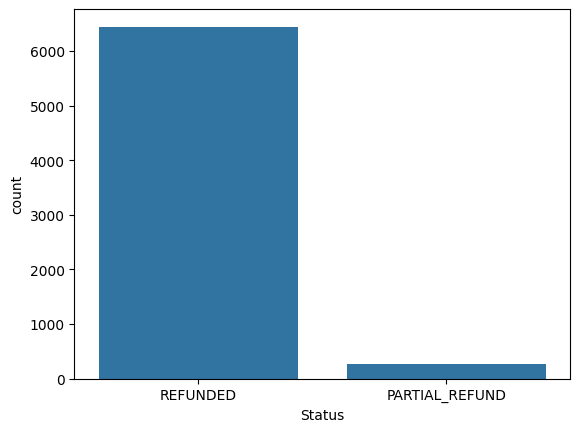

In [ ]:
def annotate (message,statut):
  if (message.find('SECTOR') or message.find('SECTORS'!=-1)) and  message.find('ONLY')!=-1  :
    return('PARTIAL_REFUND')
  else:
    return(statut)



#data annotation
df1=pd.DataFrame({'Status':[annotate(data['Reason'][i], data['Status'][i]) for i in range(len(data))]})
data['Status']=df1['Status']
#data.head()
sns.countplot(data, x="Status")

In [ ]:
data.groupby('Status').describe().T


Status        PARTIAL_REFUND           REFUNDED
Reason count             275               6444
       unique            135               2060
       top               NAN  REFUND AS PER TNC
       freq               28                153

# Data augmentation

In [ ]:


aug = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased', action="insert")
text = "The quick brown fox jumps over the lazy dog ."
augmented_text = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Original:
The quick brown fox jumps over the lazy dog .
Augmented Text:
['spotting the quick brown eye fox easily jumps over the lazy dog.']


In [ ]:
df=data.loc[data['Status'] == 'PARTIAL_REFUND']
df=pd.DataFrame(df)
df.head()



,Reason,Status
91,FULL REFUND DUE TO SCA.,PARTIAL_REFUND
92,FULL REFUND DUE TO SCA.,PARTIAL_REFUND
93,FULL REFUND DUE TO SCA.,PARTIAL_REFUND
94,FULL REFUND DUE TO SCA.,PARTIAL_REFUND
95,REFUNDS REQUEST-DUE TO FLIGHT CANCELLATION-SMR...,PARTIAL_REFUND


In [ ]:
for i in range(2):
  for reason  in df['Reason']:
    augmented_text = aug.augment(reason)
    l = [augmented_text, 'PARTIAL_REFUND']
    data.loc[len(data)] = l

<Axes: xlabel='Status', ylabel='count'>

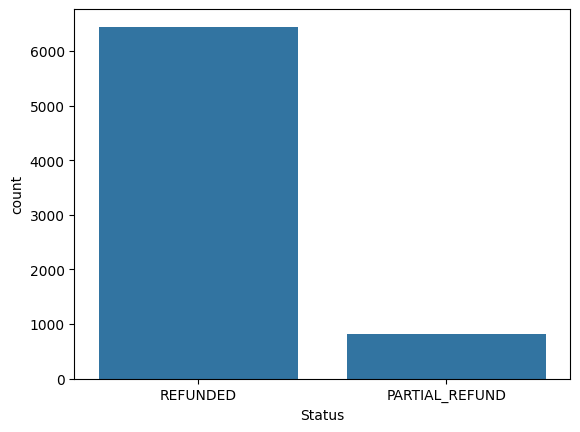

In [ ]:
sns.countplot(data, x="Status")


#Step 3. Visualize REFUNDED and  PARTIAL_REFUND  message using wordcloud


The next step is to visualize the most frequently occurring words in a given text using WordCloud.

**The WordCloud of the ‘REFUNDED’ STATUS:**

In [ ]:
comment_words = ''
stopwords = set(STOPWORDS)

df1=data.loc[data['Status'] == 'REFUNDED']
for val in df1.Reason:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

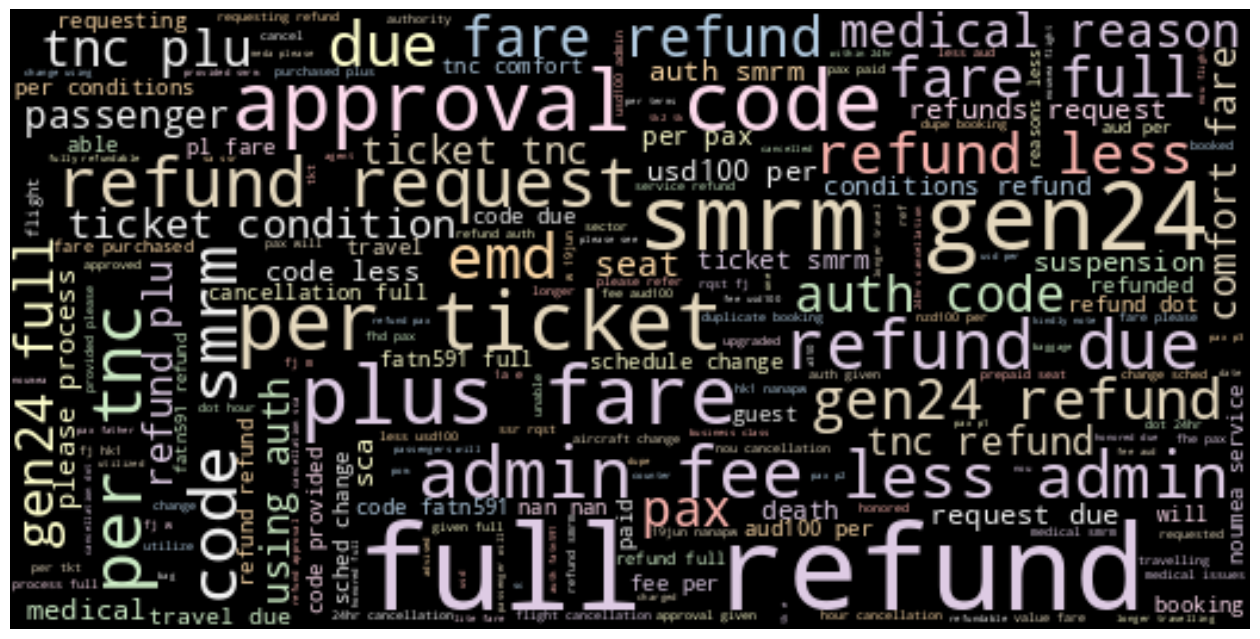

In [ ]:
refunded_status_cloud = WordCloud(width =520, height =260, stopwords = STOPWORDS, max_font_size = 50, background_color = "black", colormap = 'Pastel1').generate(comment_words)
plt.figure(figsize=(16,10))
plt.imshow(refunded_status_cloud, interpolation = 'bilinear')
plt.axis('off') # turn off axis
plt.show()


The words that appear most frequently in full refund status based on WordCloud above are: full refund, per ticket, approval code etc.





**The WordCloud of the ‘PARTIAL_REFUND’ status**

In [ ]:
comment_words = ''
stopwords = set(STOPWORDS)

df3=data.loc[data['Status'] == 'PARTIAL_REFUND']
for val in df3.Reason:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "


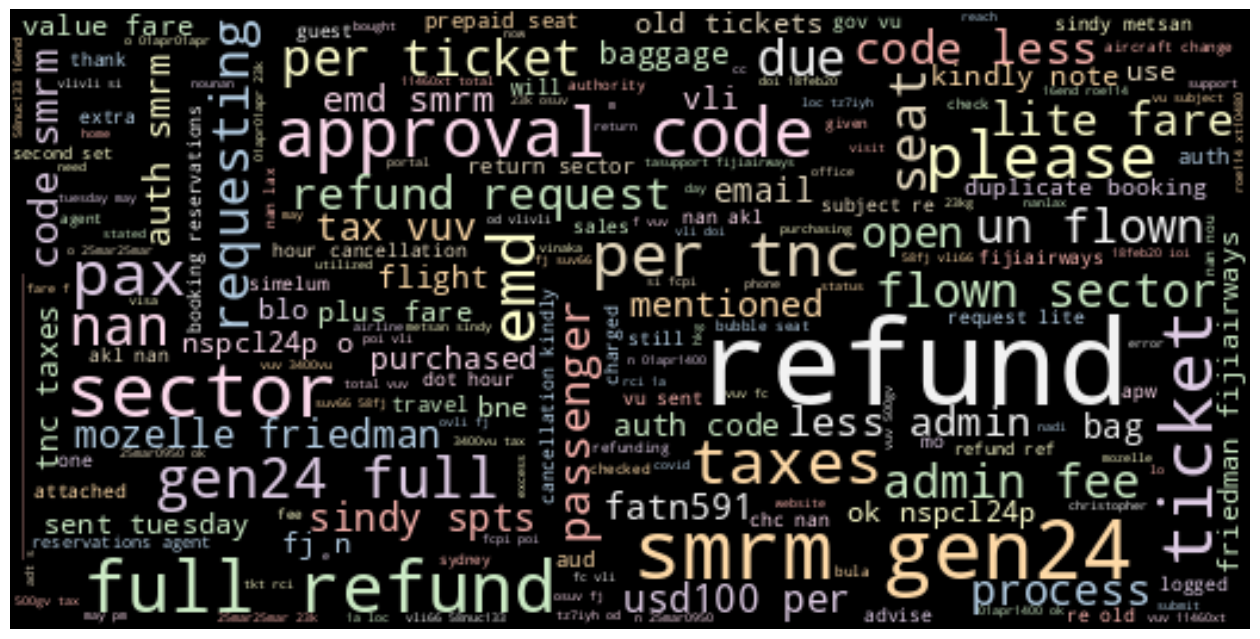

In [ ]:
partial_status_cloud = WordCloud(width =520, height =260, stopwords = STOPWORDS, max_font_size = 50, background_color = "black", colormap = 'Pastel1').generate(comment_words)
plt.figure(figsize=(16,10))
plt.imshow(partial_status_cloud, interpolation = 'bilinear')
plt.axis('off') # turn off axis
plt.show()


The words that appear most frequently in PARTIAL refund status based on WordCloud above are: refund, ticket, approval code, sector etc.


#Step 4. Text preprocessing


In [ ]:
data['Reason'] = data['Reason'].apply(lambda x: str(x).lower())
data['Reason'] = data['Reason'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))


for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')

max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['Reason'].values)
X = tokenizer.texts_to_sequences(data['Reason'].values)
seq_max_len=50
X = pad_sequences(X, maxlen=seq_max_len)

<ipython-input-14-19a523582572>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row[0] = row[0].replace('rt',' ')
<ipython-input-14-19a523582572>:6: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  row[0] = row[0].replace('rt',' ')


**post-training**

In [ ]:
import pickle

In [ ]:
# Saving the models and the Count Vectorizer converter in a pkl file so that it can
# be used in another program without trainig the models.
tokenizer_pkl_file = "tok_model.pkl"

with open(tokenizer_pkl_file, 'wb') as file:
    pickle.dump(tokenizer, file)

# TRAINING THE MODELS

Train test split

we do a train test split to divide the data into 66.66% train data and 33.33% test data.

In [ ]:
print(pd.get_dummies(data['Status']).head())
Y = pd.get_dummies(data['Status']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

   PARTIAL_REFUND  REFUNDED
0           False      True
1           False      True
2           False      True
3           False      True
4           False      True
(4870, 50) (4870, 2)
(2399, 50) (2399, 2)


**LSTM MODEL**

In [ ]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim))
model.add(SpatialDropout1D(0.6))
model.add(LSTM(lstm_out, dropout=0.7, recurrent_dropout=0.5))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
Y_test

array([[False,  True],
       [False,  True],
       [False,  True],
       ...,
       [False,  True],
       [False,  True],
       [False,  True]])

In [ ]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 2, batch_size=batch_size, verbose = 2)

Epoch 1/2
180/180 - 321s - 2s/step - accuracy: 0.8384 - loss: 0.3845
Epoch 2/2
180/180 - 322s - 2s/step - accuracy: 0.9414 - loss: 0.1696


In [ ]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

42/42 - 21s - 491ms/step - accuracy: 0.9535 - loss: 0.1239
score: 0.12
acc: 0.95


42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 497ms/step
1333


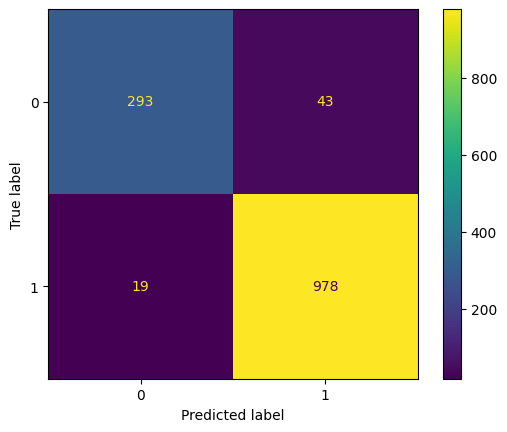

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# get the model’s prediction for the test set
predictions = model.predict(X_test)
# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)  # Assuming predictions are probabilities
print(len(X_test))

# using the model’s prediction and the true value,
# create a confusion matrix
cm = confusion_matrix(np.argmax(Y_test, axis=1), predicted_labels) # Convert Y_test to class labels




# use the built-in visualization function to generate a plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

the model does a good job at predicting the full refund and partial refund cases

**Bidirectional LSTM**

In [ ]:
embed_dim = 128
lstm_out = 196

model1 = Sequential()
model1.add(Embedding(max_fatures, embed_dim))
model1.add(SpatialDropout1D(0.4))
model1.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2)))
model1.add(Dense(2,activation='softmax'))
model1.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model1.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
Y_test

array([[False,  True],
       [False,  True],
       [False,  True],
       ...,
       [False,  True],
       [False,  True],
       [False,  True]])

In [ ]:
batch_size = 32
model1.fit(X_train, Y_train, epochs = 2, batch_size=batch_size, verbose = 2)

Epoch 1/2
153/153 - 46s - 303ms/step - accuracy: 0.9236 - loss: 0.2257
Epoch 2/2
153/153 - 82s - 534ms/step - accuracy: 0.9715 - loss: 0.0859


**post training**

In [ ]:
# Saving the models and the Count Vectorizer converter in a pkl file so that it can
# be used in another program without trainig the models.
model_pkl_file = "model.pkl"

with open(model_pkl_file, 'wb') as file:
    pickle.dump(model1, file)

75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step
2399


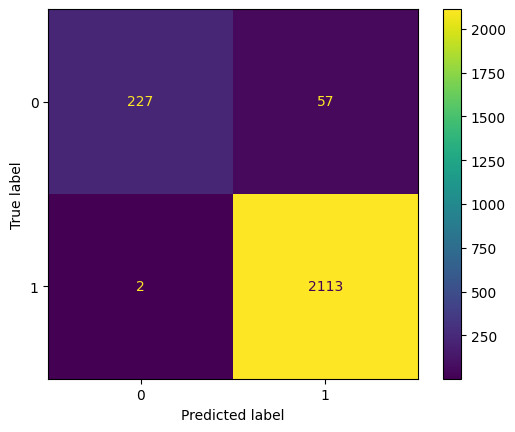

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# get the model’s prediction for the test set
predictions = model1.predict(X_test)
# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)  # Assuming predictions are probabilities
print(len(X_test))

# using the model’s prediction and the true value,
# create a confusion matrix
cm = confusion_matrix(np.argmax(Y_test, axis=1), predicted_labels) # Convert Y_test to class labels




# use the built-in visualization function to generate a plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model1.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

29/29 - 2s - 86ms/step - accuracy: 0.9666 - loss: 0.1006
score: 0.10
acc: 0.97


In [ ]:
test_sequence = tokenizer.texts_to_sequences(['full refund due to flight cancelation'])
padded_sequence = pad_sequences(test_sequence, maxlen=50)

model1.predict(padded_sequence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


array([[0.00682081, 0.9931792 ]], dtype=float32)

#GRU Model

In [ ]:
embed_dim = 128
lstm_out = 196
max_len=520
# Assuming you have a tokenizer object named 'tokenizer'
vocab_size = len(tokenizer.word_index) + 1  # +1 for the padding token

model2 = Sequential()
model2.add(Embedding(vocab_size,  # Use the correct vocabulary size here
                     embed_dim,
                     input_length = max_len))
model2.add(SpatialDropout1D(0.2))
model2.add(GRU(128, return_sequences = False))
model2.add(Dropout(0.2))
model2.add(Dense(2, activation = 'softmax'))
model2.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model2.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_2                  │ ?                           │     0 (unbuilt) │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
Y_test

array([[False,  True],
       [False,  True],
       [False,  True],
       ...,
       [False,  True],
       [False,  True],
       [False,  True]])

In [ ]:
batch_size = 32
model2.fit(X_train, Y_train, epochs = 2, batch_size=batch_size, verbose = 2)

Epoch 1/2
180/180 - 176s - 977ms/step - accuracy: 0.9158 - loss: 0.2122
Epoch 2/2
180/180 - 199s - 1s/step - accuracy: 0.9746 - loss: 0.0687


In [ ]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model2.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

42/42 - 6s - 149ms/step - accuracy: 0.9670 - loss: 0.1018
score: 0.10
acc: 0.97


42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step
1333


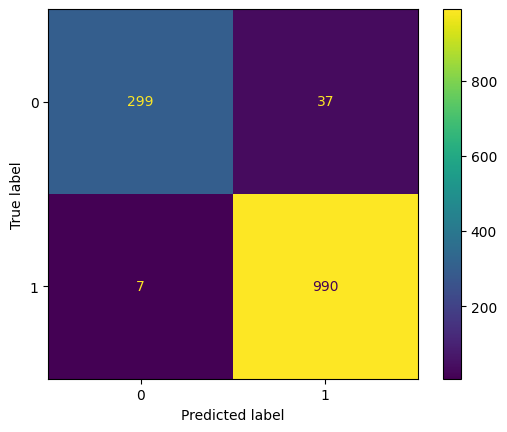

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# get the model’s prediction for the test set
predictions = model2.predict(X_test)
# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)  # Assuming predictions are probabilities
print(len(X_test))

# using the model’s prediction and the true value,
# create a confusion matrix
cm = confusion_matrix(np.argmax(Y_test, axis=1), predicted_labels) # Convert Y_test to class labels




# use the built-in visualization function to generate a plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Bidirectional LSTM and GRU have the same accuracy
